# ALS

In [1]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [2]:
# Training dataset
df_train = pd.read_csv('dataset/train.csv',
                         sep=',',
                         names = ['user_id','item_id','rating'],
                         header=0)

# rating >= 5 , relevant (1) and rating below 5 isn't relevant (0), we handle -1 as not relevant
df_train.rating = [1 if x >=5 else 0 for x in df_train.rating ]

In [3]:
df_train.head()

,user_id,item_id,rating
0,40748,9926,0
1,35757,79,1
2,18266,51,0
3,31006,8795,1
4,68084,14837,1


In [4]:
# Cargamos el dataset con los items
df_items = pd.read_csv('dataset/anime.csv',
                        sep=',',
                        names = ['anime_id','name','genre','type','episodes','rating','members'],
                        header=None,
                        encoding='latin-1')

In [5]:
df_items.head()

,anime_id,name,genre,type,episodes,rating,members
0,anime_id,name,genre,type,episodes,rating,members
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
2,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
3,28977,GintamaÂ°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
4,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572


In [6]:
# Cargamos el dataset de testing
df_test = pd.read_csv('dataset/validation.csv',
                      sep=',',
                      names=['userid', 'itemid', 'rating'],
                      header=0)


# rating >= 5 es relevante (1) y rating menor a 5 es no relevante (0)
df_test.rating = [1 if x >=5 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [7]:
df_test.head()

,userid,itemid,rating
0,25810,4789,1
1,39393,6275,1
2,2282,8675,1
3,18797,237,1
4,39248,2472,1


In [8]:
# Definicion de métricas (No editar)
# Inspirado parcialmente en https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [9]:
# Preprocesamiento de los datos a formato sparse
# Change data to map index from 0 
unique_user_ids = df_train['user_id'].unique()
unique_item_ids = df_train['item_id'].unique()

user_id_map = {uid: idx for idx, uid in enumerate(unique_user_ids)}
item_id_map = {iid: idx for idx, iid in enumerate(unique_item_ids)}

rows = []
cols = []
data = []

for row in df_train.itertuples(index=False):
    user_idx = user_id_map[row.user_id]
    item_idx = item_id_map[row.item_id]

    rows.append(user_idx)
    cols.append(item_idx)
    data.append(1) 

user_item_matrix = sparse.csr_matrix((data, (rows, cols)), shape=(len(user_id_map), len(item_id_map)))

In [10]:
def evaluate_model(model, n):
    mean_ap = 0.
    mean_ndcg = 0.
    mean_recall = 0.

    for u in user_items_test.keys():
        if u not in user_id_map:
            continue

        u_idx = user_id_map[u]
        rec = model.recommend(u_idx, user_item_matrix[u_idx], n)[0]
        relevant = set(user_items_test[u])
        hits = len(set(rec).intersection(relevant))

        rel_vector = [1 if item in relevant else 0 for item in rec]

        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n)
        mean_recall += hits / len(relevant) if relevant else 0

    total_users = len(user_items_test)
    return mean_ap / total_users, mean_ndcg / total_users, mean_recall / total_users


def show_recommendations(model, user, n):
  recommendations = model.recommend(userid=user, user_items=user_item_matrix[user], N=n)[0]
  return df_items.loc[recommendations]['name']

def show_similar_movies(model, item, n=10):
  sim_items = model.similar_items(item, n)[0]
  return df_items.loc[sim_items]['name']

In [11]:
# Cargar la matriz de géneros
anime_genres = pd.read_csv("dataset/anime_genres.csv", index_col="anime_id")

# Función de diversidad usando géneros binarios
def diversity(recommendations):
    scores = []
    for recs in recommendations.values():
        genres = set()
        for anime_id in recs:
            if anime_id in anime_genres.index:
                anime_genre_flags = anime_genres.loc[anime_id]
                genres.update(anime_genre_flags[anime_genre_flags == 1].index)
        scores.append(len(genres))
    return sum(scores) / len(scores)

# Popularidad para novelty
item_popularity = df_train['item_id'].value_counts().to_dict()

def calculate_novelty(recommendations):
    novelty = 0
    for recs in recommendations.values():
        novelty += np.sum([
            np.log2(1 + len(df_train)) / item_popularity.get(anime_id, 1)
            for anime_id in recs
        ])
    return novelty / len(recommendations)


# 4 CASES

In [12]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(user_item_matrix)

/home/roa/universidad/recsys/anime-recommendation/t1recsys/lib/python3.8/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
show_recommendations(model_als, user=99, n=10)

426                        Isekai no Seikishi Monogatari
113                                      Hunter x Hunter
123                                     Kuroko no Basket
241                          Nodame Cantabile: Paris-hen
327                                Kodomo no Omocha (TV)
643                                 Akatsuki no Yona OVA
821    Prince of Tennis: Another Story - Messages Fro...
264                               Initial D Fourth Stage
478                                      Death Billiards
524                                          City Hunter
Name: name, dtype: object

In [14]:
show_similar_movies(model_als, item=1, n=10)

1                                        Kimi no Na wa.
618                                     Yuru Yuriâªâª
3608                       Chou Denji Robo Combattler V
2015                                          Rain Town
1584                Baka to Test to Shoukanjuu Specials
1218                    Suzumiya Haruhi-chan no Yuuutsu
2341                                      Kikoushi Enma
769     Mondaiji-tachi ga Isekai kara Kuru Sou Desu yo?
1040                                 Mirai Nikki Redial
1273                                YuâGiâOh! Arc-V
Name: name, dtype: object

In [15]:
recommendations_case1 = {}
for u in user_items_test.keys():
    if u in user_id_map:
        u_idx = user_id_map[u]
        recs = model_als.recommend(u_idx, user_item_matrix[u_idx], N=10)[0]
        recommendations_case1[u] = [unique_item_ids[i] for i in recs]

maprec1, ndcg1, recall1 = evaluate_model(model_als, n=10)
div1 = diversity(recommendations_case1)
nov1 = calculate_novelty(recommendations_case1)

print("CASE 1")
print(f"MAP@10: {maprec1:.4f}")
print(f"NDCG@10: {ndcg1:.4f}")
print(f"Recall@10: {recall1:.4f}")
print(f"Diversity: {div1:.2f}")
print(f"Novelty: {nov1:.4f}")


CASE 1
MAP@10: 0.0001
NDCG@10: 0.0007
Recall@10: 0.0020
Diversity: 20.25
Novelty: 4.4463


# Case 2

In [16]:
model_als_2 = implicit.als.AlternatingLeastSquares(factors=50, iterations=15, regularization=0.01, use_gpu=False)
model_als_2.fit(user_item_matrix)

  0%|          | 0/15 [00:00<?, ?it/s]

In [17]:
recommendations_case2 = {}
for u in user_items_test.keys():
    if u in user_id_map:
        u_idx = user_id_map[u]
        recs = model_als_2.recommend(u_idx, user_item_matrix[u_idx], N=10)[0]
        recommendations_case2[u] = [unique_item_ids[i] for i in recs]

maprec2, ndcg2, recall2 = evaluate_model(model_als_2, n=10)
div2 = diversity(recommendations_case2)
nov2 = calculate_novelty(recommendations_case2)

print("CASE 2")
print(f"MAP@10: {maprec2:.4f}")
print(f"NDCG@10: {ndcg2:.4f}")
print(f"Recall@10: {recall2:.4f}")
print(f"Diversity: {div2:.2f}")
print(f"Novelty: {nov2:.4f}")


CASE 2
MAP@10: 0.0001
NDCG@10: 0.0006
Recall@10: 0.0017
Diversity: 20.94
Novelty: 3.0572


# Case 3

In [18]:
model_als_3 = implicit.als.AlternatingLeastSquares(factors=150, iterations=20, regularization=0.05, use_gpu=False)
model_als_3.fit(user_item_matrix)

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
recommendations_case3 = {}
for u in user_items_test.keys():
    if u in user_id_map:
        u_idx = user_id_map[u]
        recs = model_als_3.recommend(u_idx, user_item_matrix[u_idx], N=10)[0]
        recommendations_case3[u] = [unique_item_ids[i] for i in recs]

maprec3, ndcg3, recall3 = evaluate_model(model_als_3, n=10)
div3 = diversity(recommendations_case3)
nov3 = calculate_novelty(recommendations_case3)

print("CASE 3")
print(f"MAP@10: {maprec3:.4f}")
print(f"NDCG@10: {ndcg3:.4f}")
print(f"Recall@10: {recall3:.4f}")
print(f"Diversity: {div3:.2f}")
print(f"Novelty: {nov3:.4f}")

CASE 3
MAP@10: 0.0003
NDCG@10: 0.0015
Recall@10: 0.0032
Diversity: 20.56
Novelty: 6.0065


# Case 4

In [20]:
model_als_4 = implicit.als.AlternatingLeastSquares(factors=200, iterations=25, regularization=0.1, use_gpu=False)
model_als_4.fit(user_item_matrix)

  0%|          | 0/25 [00:00<?, ?it/s]

In [21]:
recommendations_case4 = {}
for u in user_items_test.keys():
    if u in user_id_map:
        u_idx = user_id_map[u]
        recs = model_als_4.recommend(u_idx, user_item_matrix[u_idx], N=10)[0]
        recommendations_case4[u] = [unique_item_ids[i] for i in recs]

maprec4, ndcg4, recall4 = evaluate_model(model_als_4, n=10)
div4 = diversity(recommendations_case4)
nov4 = calculate_novelty(recommendations_case4)

print("CASE 4")
print(f"MAP@10: {maprec4:.4f}")
print(f"NDCG@10: {ndcg4:.4f}")
print(f"Recall@10: {recall4:.4f}")
print(f"Diversity: {div4:.2f}")
print(f"Novelty: {nov4:.4f}")


CASE 4
MAP@10: 0.0003
NDCG@10: 0.0012
Recall@10: 0.0017
Diversity: 20.24
Novelty: 7.6047


# Best Case: Case 3

- factors=150
- iterations=20 
- regularization=0.05

# Graphs

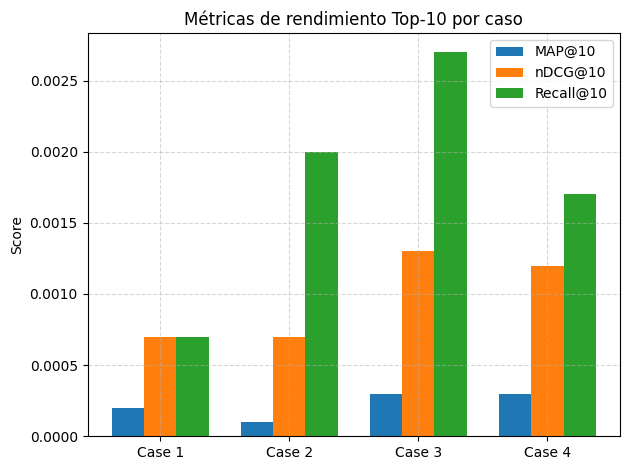

In [22]:
import matplotlib.pyplot as plt

cases = ['Case 1', 'Case 2', 'Case 3', 'Case 4']
map_vals = [0.0002, 0.0001, 0.0003, 0.0003]
ndcg_vals = [0.0007, 0.0007, 0.0013, 0.0012]
recall_vals = [0.0007, 0.0020, 0.0027, 0.0017]

x = range(len(cases))
width = 0.25

plt.bar([p - width for p in x], map_vals, width=width, label='MAP@10')
plt.bar(x, ndcg_vals, width=width, label='nDCG@10')
plt.bar([p + width for p in x], recall_vals, width=width, label='Recall@10')

plt.xticks(x, cases)
plt.ylabel("Score")
plt.title("Métricas de rendimiento Top-10 por caso")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


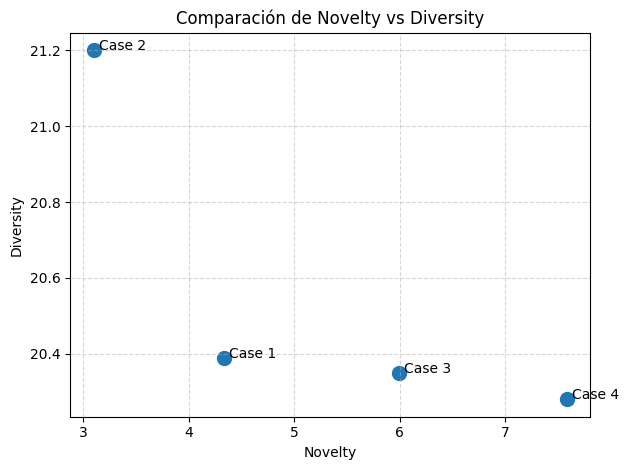

In [23]:
novelty_vals = [4.33, 3.10, 5.99, 7.58]
diversity_vals = [20.39, 21.20, 20.35, 20.28]

plt.scatter(novelty_vals, diversity_vals, s=100)

for i, txt in enumerate(cases):
    plt.annotate(txt, (novelty_vals[i] + 0.05, diversity_vals[i]))

plt.xlabel("Novelty")
plt.ylabel("Diversity")
plt.title("Comparación de Novelty vs Diversity")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
